# Сверточная сеть в Keras

На лекции мы узнали, что свертки можно комбинировать, применяя друг за другом. Это увеличивает их рецептивное поле и позволяет выучить более сложные признаки. 

В этом уроке мы с вами обучим нашу первую свертоную нейронную сеть для задачи классификации одежды. Вот как будет выглядеть наш датасет

<img src="https://1.bp.blogspot.com/-AIPR5UuydTY/WbCLlGEmoAI/AAAAAAAAA2U/Teu6q2FF9LslUL6t6Qn5YjzGWNfHC7y7wCLcBGAs/s1600/fashion-mnist-sprite.png" width="600">

Он называется FashionMnist. Название не случайно похоже на Mnist -- с рукописными цифрами -- FashionMnist придумали как замену Mnist, потому что он стал уж слишком простым для современных нейронных сетей. Как вы помните, на нем мы без труда достигли 97-98% точности. 

In [1]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt

2.12.0


In [2]:
mapping = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress",
           4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag",
           9: "Ankle boot"}  # датасет содержит 10 классов

def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {mapping[labels[i]]}. Pred: {mapping[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {mapping[labels[i]]}")

(60000, 28, 28) (10000, 28, 28)


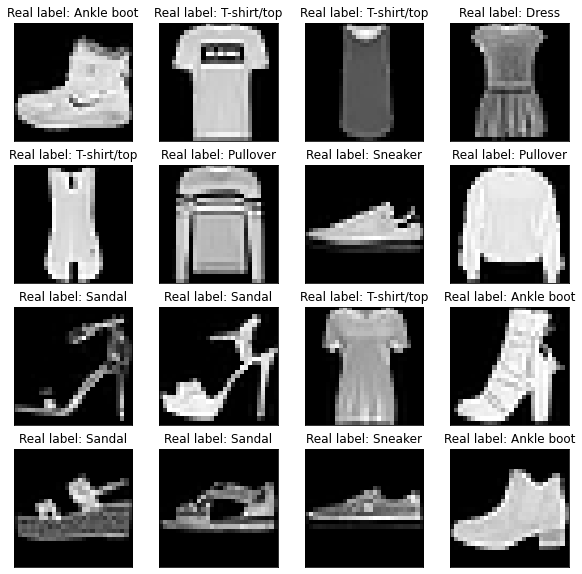

In [3]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

show_mnist(x_train, y_train)
print(x_train.shape, x_test.shape)

In [4]:
# tf.debugging.set_log_device_placement(True)
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=x_train, y=y_train,
          batch_size=128, epochs=15,
          validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
469/469 [==============================] - 4s 7ms/step - loss: 0.5067 - accuracy: 0.8234 - val_loss: 0.4201 - val_accuracy: 0.8503
Epoch 2/15
469/469 [==============================] - 3s 7ms/step - loss: 0.3743 - accuracy: 0.8670 - val_loss: 0.3764 - val_accuracy: 0.8668
Epoch 3/15
469/469 [==========

In [5]:
# помним, что для работы со сверточной сетью нам нужны четырех мерные тензоры - меняем размеры
x_train = x_train[..., None]
x_test = x_test[..., None]
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


Мы построим архитектуру по следующим правилам:
* Будем использовать сверточные слои 3х3 с активацией ReLU
* За сверткой будет следовать слой MaxPool
* Количество фильтров при уменьшении тензора в два раза (т.е. после MaxPool) будем увеличивать в два раза

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                                 activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
# т.к. мы используем padding='same', значит, после двух пулингов размер уменьшится ровно в два раза
# можем это увидеть на summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


Мы получили тензор размера (7, 7, 64). Для превращения его в классы надо применить полносвязный слои чтобы предсказать 10 классов.
Только перед тем как мы применим полносвязный слой - мы должны "вытянуть" то, что мыв ему подаем на вход в одну строчку, ведь он
ожидает вектор, а не многомерный тензор.
Воспользуемся **tf.keras.layers.Flatten()**.

In [7]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

Обратите внимание, количество параметров почти в два раза меньше, чем для полносвязной сети.

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(x=x_train, y=y_train,
          batch_size=128, epochs=20,
          validation_data=(x_test, y_test))


Epoch 1/20
469/469 [==============================] - 8s 15ms/step - loss: 0.4909 - accuracy: 0.8276 - val_loss: 0.3656 - val_accuracy: 0.8700
Epoch 2/20
469/469 [==============================] - 7s 15ms/step - loss: 0.3204 - accuracy: 0.8867 - val_loss: 0.3093 - val_accuracy: 0.8906
Epoch 3/20
469/469 [==============================] - 7s 15ms/step - loss: 0.2771 - accuracy: 0.9007 - val_loss: 0.3090 - val_accuracy: 0.8869
Epoch 4/20
469/469 [==============================] - 7s 15ms/step - loss: 0.2479 - accuracy: 0.9106 - val_loss: 0.2784 - val_accuracy: 0.9010
Epoch 5/20
469/469 [==============================] - 7s 15ms/step - loss: 0.2246 - accuracy: 0.9184 - val_loss: 0.2587 - val_accuracy: 0.9088
Epoch 6/20
469/469 [==============================] - 7s 14ms/step - loss: 0.2057 - accuracy: 0.9249 - val_loss: 0.2511 - val_accuracy: 0.9097
Epoch 7/20
469/469 [==============================] - 7s 15ms/step - loss: 0.1947 - accuracy: 0.9291 - val_loss: 0.2521 - val_accuracy: 0.9115

In [10]:
# сейчам перед пуллингом ипользуется два светрочных слоя
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                                activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                                activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                                activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                                activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=x_train, y=y_train,
          batch_size=128, epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
469/469 [==============================] - 11s 20ms/step - loss: 0.4888 - accuracy: 0.8217 - val_loss: 0.3518 - val_accuracy: 0.8749
Epoch 2/20
469/469 [==============================] - 9s 20ms/step - loss: 0.2838 - accuracy: 0.8977 - val_loss: 0.2775 - val_accuracy: 0.9022
Epoch 3/20
469/469 [==============================] - 9s 19ms/step - loss: 0.2340 - accuracy: 0.9143 - val_loss: 0.2469 - val_accuracy: 0.9099
Epoch 4/20
469/469 [==============================] - 9s 19ms/step - loss: 0.2057 - accuracy: 0.9251 - val_loss: 0.2306 - val_accuracy: 0.9165
Epoch 5/20
469/469 [==============================] - 9s 19ms/step - loss: 0.1817 - accuracy: 0.9341 - val_loss: 0.2300 - val_accuracy: 0.9206
Epoch 6/20
469/469 [==============================] - 9s 19ms/step - loss: 0.1624 - accuracy: 0.9406 - val_loss: 0.2192 - val_accuracy: 0.9245
Epoch 7/20
469/469 [==============================] - 9s 19ms/step - loss: 0.1455 - accuracy: 0.9472 - val_loss: 0.2384 - val_accuracy: 0.921